In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from scipy.interpolate import make_interp_spline
from itertools import chain

In [2]:
#data process 
#读入, 归一化, 装载dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LSTM_PATH = 'E:\\实验数据\\python\\LSTM_data\\test.pkl'
time_seq_len = 24
torch.manual_seed(60)

def load_data(file_name):
    global MAX, MIN
    df = pd.read_csv(file_name, encoding='gbk')
    columns = df.columns
    df.fillna(df.mean(), inplace=True)
    
    MAX = np.max(df[columns[3]])
    MIN = np.min(df[columns[3]])
    
    for i in range(len(columns)):
        max_v = np.max(df[columns[i]])
        min_v = np.min(df[columns[i]])
        df[columns[i]] = (df[columns[i]] - min_v) / (max_v - min_v)

    return df


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)
    

def nn_seq(file_name, batch_size):
    global test_len
    print('data processing...')
    data = load_data(file_name)
    load = data[data.columns[3]]
    load = load.tolist()
    load = torch.FloatTensor(load).view(-1)
    data = data.values.tolist()
    seq = []
    for i in range(len(data) - time_seq_len):
        train_seq = []
        train_label = []
        for j in range(i, i + time_seq_len):   #每24个时刻作为一个输入
            x = [load[j]]
            for c in range(0,3):
                x.append(data[j][c])
            train_seq.append(x)
        train_label.append(load[i+time_seq_len])
        train_seq = torch.FloatTensor(train_seq)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq.append((train_seq, train_label))
#     print(seq[:5])
            

    Dtr = seq[0:int(len(seq) * 0.7)]    #将所有数据中的前百分之七十作为训练集
    Dte = seq[int(len(seq) * 0.7):len(seq)]
    test_len = len(Dte)

    train_len = int(len(Dtr) / batch_size) * batch_size  #可能训练集不能被 batch_size整除, 因此这里取个最大能整除的长度
    test_len = int(len(Dte) / batch_size) * batch_size
    Dtr, Dte = Dtr[:train_len], Dte[:test_len]

    train = MyDataset(Dtr)
    test = MyDataset(Dte)

    Dtr = DataLoader(dataset=train, batch_size=batch_size, shuffle=False, num_workers=0)
    Dte = DataLoader(dataset=test, batch_size=batch_size, shuffle=False, num_workers=0)

    return Dtr, Dte


def get_mape(x, y):
    """
    :param x: true value
    :param y: pred value
    :return: mape
    """
    error = x-y
    return np.mean(error ** 2) ** 0.5


In [3]:
# dt, de = nn_seq('E:\实验数据\python\LSTM_data\data.csv', 5)
# print(len(dt))
# print(len(de))
# print(test_len)

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        seq_len = input_seq.shape[1] # (5, 24)
        # input(batch_size, seq_len, input_size)
        input_seq = input_seq.view(self.batch_size, seq_len, 4)  # (5, 24, 1)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 24, 64)
        output = output.contiguous().view(self.batch_size * seq_len, self.hidden_size) # (5 * 24, 64)
        pred = self.linear(output) # pred(150, 1)
        pred = pred.view(self.batch_size, seq_len, -1) # (5, 24, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [5]:
ls = []
def LSTM_train(name, b):
    Dtr, Dte = nn_seq(file_name=name, batch_size=b)
    input_size, hidden_size, num_layers, output_size = 4, 64, 1, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # 训练
    epochs = 100
    cnt = 0
    for i in range(epochs):
        cnt = 0
        print('epoch', i)
        for (seq, label) in Dtr:
            cnt += 1
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if cnt % 100 == 0:
                print('epoch', i, ':', cnt - 100, '~', cnt, loss.item())
        ls.append(loss.item())
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, LSTM_PATH)

LSTM_train('E:\实验数据\python\LSTM_data\\add_WT_feature.csv', 5)

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.020735735073685646
epoch 0 : 100 ~ 200 0.016559669747948647
epoch 1
epoch 1 : 0 ~ 100 0.007813104428350925
epoch 1 : 100 ~ 200 0.006930350326001644
epoch 2
epoch 2 : 0 ~ 100 0.004584317095577717
epoch 2 : 100 ~ 200 0.005269965156912804
epoch 3
epoch 3 : 0 ~ 100 0.004365620203316212
epoch 3 : 100 ~ 200 0.00413705687969923
epoch 4
epoch 4 : 0 ~ 100 0.0042367964051663876
epoch 4 : 100 ~ 200 0.0031044241040945053
epoch 5
epoch 5 : 0 ~ 100 0.0040749842301011086
epoch 5 : 100 ~ 200 0.002171145286411047
epoch 6
epoch 6 : 0 ~ 100 0.003844653023406863
epoch 6 : 100 ~ 200 0.001547443331219256
epoch 7
epoch 7 : 0 ~ 100 0.0035523935221135616
epoch 7 : 100 ~ 200 0.001289759879000485
epoch 8
epoch 8 : 0 ~ 100 0.003256210358813405
epoch 8 : 100 ~ 200 0.00123123312368989
epoch 9
epoch 9 : 0 ~ 100 0.002984491642564535
epoch 9 : 100 ~ 200 0.0011843523243442178
epoch 10
epoch 10 : 0 ~ 100 0.0027751896996051073
epoch 10 : 100 ~ 200 0.0010898140026256442
epoch

epoch 89 : 0 ~ 100 0.0008096054079942405
epoch 89 : 100 ~ 200 0.0005810087313875556
epoch 90
epoch 90 : 0 ~ 100 0.0005389497382566333
epoch 90 : 100 ~ 200 0.0007900404743850231
epoch 91
epoch 91 : 0 ~ 100 0.0003920088056474924
epoch 91 : 100 ~ 200 0.0006809571059420705
epoch 92
epoch 92 : 0 ~ 100 0.0005238127196207643
epoch 92 : 100 ~ 200 0.0013697076356038451
epoch 93
epoch 93 : 0 ~ 100 0.0004087811685167253
epoch 93 : 100 ~ 200 0.0010602738475427032
epoch 94
epoch 94 : 0 ~ 100 0.0006632886943407357
epoch 94 : 100 ~ 200 0.0015520320739597082
epoch 95
epoch 95 : 0 ~ 100 0.0005276289884932339
epoch 95 : 100 ~ 200 0.0008911566692404449
epoch 96
epoch 96 : 0 ~ 100 0.00046692462638020515
epoch 96 : 100 ~ 200 0.00263041234575212
epoch 97
epoch 97 : 0 ~ 100 0.00027073262026533484
epoch 97 : 100 ~ 200 0.0005274518625810742
epoch 98
epoch 98 : 0 ~ 100 0.0008942143758758903
epoch 98 : 100 ~ 200 0.0006502215983346105
epoch 99
epoch 99 : 0 ~ 100 0.00027747853891924024
epoch 99 : 100 ~ 200 0.00230

data processing...
loading model...
predicting...
rmse: 0.35762589355413743


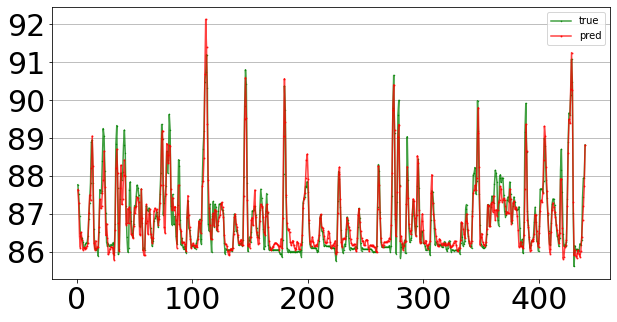

In [6]:
def test(name, b):
    global MAX, MIN
    Dtr, Dte= nn_seq(file_name=name, batch_size=b)
    pred = []
    y = []
    print('loading model...')
    input_size, hidden_size, num_layers, output_size = 4, 64, 1, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    model.load_state_dict(torch.load(LSTM_PATH)['model'])
    model.eval()
    print('predicting...')
    for (seq, target) in Dte:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq_len = seq.shape[1]
        seq = seq.view(model.batch_size, seq_len, 4)  # (5, 24, 1)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (MAX - MIN) * y + MIN
    pred = (MAX - MIN) * pred + MIN
    print('rmse:', get_mape(y, pred))
    # plot
    plt.figure(1, figsize=(10, 5))
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    x = [i for i in range(1, test_len+1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 600)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()
    
    #保存 rmse
    a1 = []
    for i in range(len(pred)):
        a1.append(pred[i].item())
    df1 = pd.DataFrame(data=a1, columns=['y'])
    df1.to_csv('C:/Users/XuYi/Desktop/论文素材/数据/LSTM_EWT_predict.csv',index=False)

test('E:\实验数据\python\LSTM_data\\add_WT_feature.csv', 5)

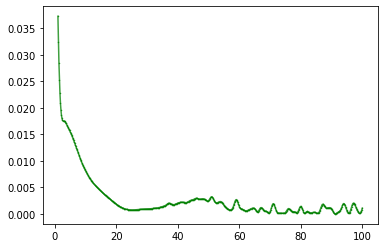

In [7]:
x = [i for i in range(1, len(ls)+1)]
x_smooth = np.linspace(np.min(x), np.max(x), 600)
y_smooth = make_interp_spline(x, ls)(x_smooth)
plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')